# Importing Packages

In [43]:
import json
import os

In [44]:
from qiime2.plugins import feature_table
from qiime2 import Artifact
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import biom
import seaborn as sns

## Importing Data

In [45]:
## Obtaining file paths
with open("config/data-params.json") as fh:
    file_paths = json.load(fh)

In [46]:
feature_table = Artifact.load(file_paths["feature_table_path"])
metadata = pd.read_csv(file_paths["metadata_path"], sep='\t', index_col=0)

/var/folders/0n/ts4w12h13klbffn_h351p4f80000gn/T/ipykernel_2693/706560901.py:2: DtypeWarning: Columns (1,2,3,4,6,7,8,10,11,12,13,14,17,18,19,20,25,26,27,29,30,31,32,33,34,35,36,37,38,40,41,42,43,44,45,46,55,56,57,61,62,63,64,65,66,67,69,70,71,72,73,75,76,78,80,82,83,84,85,86,87,88,89,90,91,92,95,98,99,102,103,104,105,106,107,108,109,111,119,121,122,123,124,125,126,127,128,129,130,131,132,133,134,136,138,139,141,142,143,144,145,146,147,148,152,153,155,156,157,160,164,165,168,169,170,172,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(file_paths["metadata_path"], sep='\t', index_col=0)


In [47]:
biom_table = feature_table.view(biom.Table)
print(biom_table.head())

# Constructed from biom file
#OTU ID	11666.BLANK7.7B	11666.BLANK5.5B	11666.G0341A	11666.BLANK3.3A	11666.BLANK5.5E
AACATAAGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGTAGGTGGTCTGTTAAGTCAGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGCCCGGAATCACTGGGCGTAAAGGGCGCGTAGGTGGTCTGTTAAGTCAGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGTCCGGAAACACTGGGCGTAAAGGGCGCGTAGGCGGTCTGTTAAGTCGGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCATAAAGGGCGCGTAGGTGGTTTGTTAAGTCAGATGTGAAATGTAGGGGCTCAACCCCTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGAGCGCGTAGGTGGTCTGTTAAGTCAGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0


In [48]:
metadata.head()

,abdominal_obesity_idf_v2,abdominal_obesity_ncep_v2,ac_ratio_gt30,ac_ratio_gt30_v2,age_units,age_v2,agegroup_c6_nhanes_v2,agegroup_c6_v2,anonymized_name,antibiotic,...,taxon_id,title,type_stool,us_born_v2,weight_norm_overall_v2,weight_units,yes_no,yogurt,yrs_btwn_viv2,yrsus_c2_v2
sample_name,,,,,,,,,,,,,,,,,,,,,
11666.BLANK1.1A,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1A,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable
11666.BLANK1.1A.ITS,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1A.ITS,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable
11666.BLANK1.1B,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1B,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable
11666.BLANK1.1B.ITS,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1B.ITS,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable
11666.BLANK1.1C,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1C,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable


## Missing Data Analysis

In [49]:
# Function for single representation for missing values
def missing_values(col, type='categorical'):
    temp = col.apply(lambda x: np.nan if x == 'not applicable' or x == 'not provided' else x)
    if type == 'numeric':
        temp = temp.apply(lambda x: x if pd.isnull(x) else np.float64(x))
    return temp

In [50]:
# Potential Columns -- more to be added 
features = ['abdominal_obesity_ncep_v2', 'ckd_v2','diabetes2_v2','hypertension2_v2',
            'precvd_v2', 'elevated_bp_selfmeds_v2', 'dyslipidemia_v2',
            'gender_v2','agegroup_c6_v2','bmigrp_c6_v2','center','us_born_v2','income_c5_v2']
disease_cols = ['abdominal_obesity_ncep_v2', 'ckd_v2','diabetes2_v2','hypertension2_v2','precvd_v2', 'elevated_bp_selfmeds_v2','dyslipidemia_v2']

In [51]:
metadata['ckd_v2'].value_counts()

1                 1746
2                 1189
not applicable     596
3                  167
2.0                 17
4                   14
1.0                  8
5                    7
not provided         7
Name: ckd_v2, dtype: int64

In [52]:
missing_values(metadata['ckd_v2'],'numeric').value_counts()

1.0    1754
2.0    1206
3.0     167
4.0      14
5.0       7
Name: ckd_v2, dtype: int64

# Subset of Metadata

In [53]:
sub_metadata = metadata[features]
sub_metadata.head()

,abdominal_obesity_ncep_v2,ckd_v2,diabetes2_v2,hypertension2_v2,precvd_v2,elevated_bp_selfmeds_v2,dyslipidemia_v2,gender_v2,agegroup_c6_v2,bmigrp_c6_v2,center,us_born_v2,income_c5_v2
sample_name,,,,,,,,,,,,,
11666.BLANK1.1A,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable
11666.BLANK1.1A.ITS,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable
11666.BLANK1.1B,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable
11666.BLANK1.1B.ITS,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable
11666.BLANK1.1C,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable


In [54]:
numeric_col = [
    'abdominal_obesity_ncep_v2','ckd_v2','diabetes2_v2',
    'hypertension2_v2','precvd_v2','elevated_bp_selfmeds_v2',
    'dyslipidemia_v2','agegroup_c6_v2',
    'bmigrp_c6_v2','us_born_v2','income_c5_v2']
categorical_col = ['center','gender_v2']

## Defining missing values

In [55]:
sub_metadata.loc[:,numeric_col] = sub_metadata.loc[:,numeric_col].apply(lambda x: missing_values(x,'numeric'))
sub_metadata.loc[:,categorical_col] = sub_metadata.loc[:,categorical_col].apply(lambda x: missing_values(x,'categorical'))

/var/folders/0n/ts4w12h13klbffn_h351p4f80000gn/T/ipykernel_2693/289276134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_metadata.loc[:,numeric_col] = sub_metadata.loc[:,numeric_col].apply(lambda x: missing_values(x,'numeric'))
/var/folders/0n/ts4w12h13klbffn_h351p4f80000gn/T/ipykernel_2693/289276134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_metadata.loc[:,categorical_col] = sub_metadata.loc[:,categorical_col].apply(lambda x: missing_values(x,'categorical'))


In [56]:
sub_metadata[disease_cols].isnull().sum() * 100 / len(sub_metadata) # calculates percent of nan in column


abdominal_obesity_ncep_v2    42.02471
ckd_v2                       41.95095
diabetes2_v2                 41.89563
hypertension2_v2             41.80343
precvd_v2                    41.80343
elevated_bp_selfmeds_v2      41.80343
dyslipidemia_v2              41.95095
dtype: float64

## EDA on Subset of Metadata

### Disease Counts

In [57]:
def create_bar_col_binary(df, col_name):
    ax = df[col_name].fillna(-1).value_counts().sort_index(ascending=False).plot(kind='barh')
    ax.set_xlabel('count')
    ax.set_ylabel('outcome')
    ax.set_title(col_name)

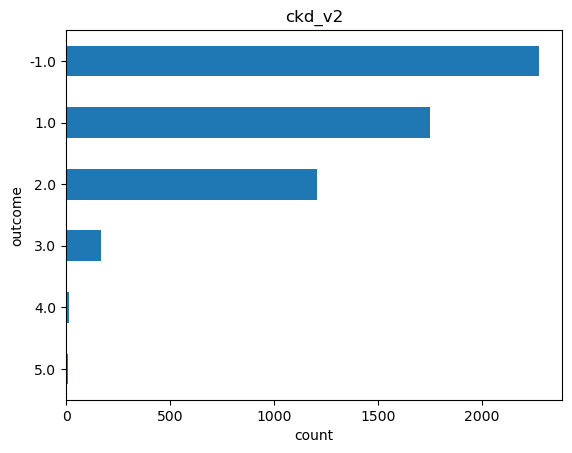

In [58]:
create_bar_col_binary(sub_metadata, 'ckd_v2')

### Gender Counts

<AxesSubplot:>

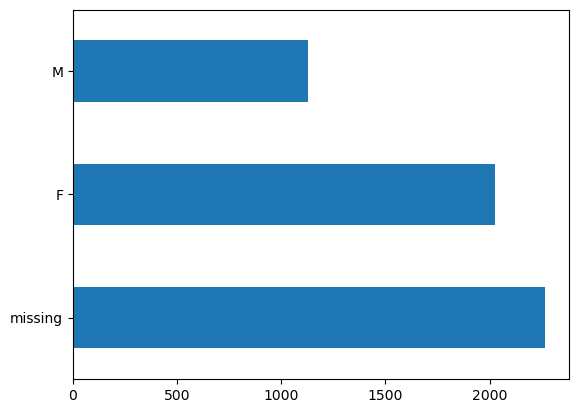

In [59]:
sub_metadata['gender_v2'].fillna('missing').value_counts().plot(kind='barh')

### Center Counts

<AxesSubplot:>

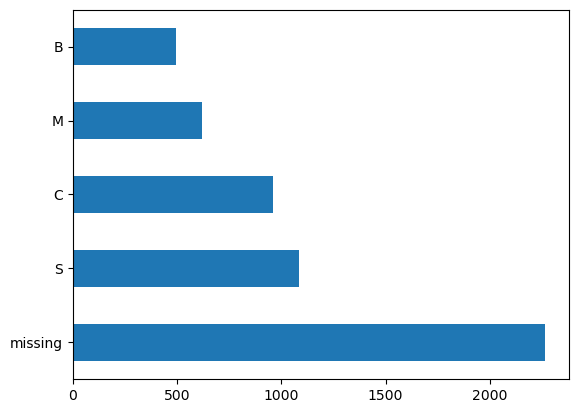

In [60]:
sub_metadata['center'].fillna('missing').value_counts().plot(kind='barh')

# Co-occurence

In [61]:
sub_metadata_no_nan = sub_metadata.dropna()
sub_metadata_no_nan

,abdominal_obesity_ncep_v2,ckd_v2,diabetes2_v2,hypertension2_v2,precvd_v2,elevated_bp_selfmeds_v2,dyslipidemia_v2,gender_v2,agegroup_c6_v2,bmigrp_c6_v2,center,us_born_v2,income_c5_v2
sample_name,,,,,,,,,,,,,
11666.G0001A,1.0,1.0,2.0,1.0,0.0,1.0,0.0,F,4.0,4.0,M,0.0,1.0
11666.G0001L,1.0,1.0,2.0,1.0,0.0,1.0,0.0,F,4.0,4.0,M,0.0,1.0
11666.G0003A,1.0,1.0,1.0,0.0,0.0,0.0,0.0,F,4.0,3.0,B,1.0,4.0
11666.G0003L,1.0,1.0,1.0,0.0,0.0,0.0,0.0,F,4.0,3.0,B,1.0,4.0
11666.G0004A,0.0,2.0,2.0,1.0,0.0,1.0,0.0,M,5.0,3.0,B,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11666.G1777A,0.0,2.0,1.0,1.0,0.0,1.0,1.0,M,3.0,3.0,C,1.0,4.0
11666.G1778A,1.0,2.0,2.0,1.0,1.0,1.0,0.0,F,6.0,3.0,S,0.0,3.0
11666.G1779A,1.0,1.0,3.0,1.0,0.0,1.0,0.0,F,5.0,3.0,S,0.0,2.0


### Converting diabetes and ckd into binary variables

In [62]:
diabetes_binary = {1.0:0.0,
                   2.0:0.0,
                   3.0:1.0}
ckd_binary = {1.0:0.0, 
              2.0:1.0,
              3.0:1.0,
              4.0:1.0,
              5.0:1.0}

In [63]:
sub_metadata_no_nan['diabetes2_v2'] = sub_metadata_no_nan['diabetes2_v2'].apply(lambda x: diabetes_binary[x])
sub_metadata_no_nan['ckd_v2'] = sub_metadata_no_nan['ckd_v2'].apply(lambda x:ckd_binary[x])

/var/folders/0n/ts4w12h13klbffn_h351p4f80000gn/T/ipykernel_2693/2844572320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_metadata_no_nan['diabetes2_v2'] = sub_metadata_no_nan['diabetes2_v2'].apply(lambda x: diabetes_binary[x])
/var/folders/0n/ts4w12h13klbffn_h351p4f80000gn/T/ipykernel_2693/2844572320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_metadata_no_nan['ckd_v2'] = sub_metadata_no_nan['ckd_v2'].apply(lambda x:ckd_binary[x])


In [64]:
sub_metadata_no_nan

,abdominal_obesity_ncep_v2,ckd_v2,diabetes2_v2,hypertension2_v2,precvd_v2,elevated_bp_selfmeds_v2,dyslipidemia_v2,gender_v2,agegroup_c6_v2,bmigrp_c6_v2,center,us_born_v2,income_c5_v2
sample_name,,,,,,,,,,,,,
11666.G0001A,1.0,0.0,0.0,1.0,0.0,1.0,0.0,F,4.0,4.0,M,0.0,1.0
11666.G0001L,1.0,0.0,0.0,1.0,0.0,1.0,0.0,F,4.0,4.0,M,0.0,1.0
11666.G0003A,1.0,0.0,0.0,0.0,0.0,0.0,0.0,F,4.0,3.0,B,1.0,4.0
11666.G0003L,1.0,0.0,0.0,0.0,0.0,0.0,0.0,F,4.0,3.0,B,1.0,4.0
11666.G0004A,0.0,1.0,0.0,1.0,0.0,1.0,0.0,M,5.0,3.0,B,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11666.G1777A,0.0,1.0,0.0,1.0,0.0,1.0,1.0,M,3.0,3.0,C,1.0,4.0
11666.G1778A,1.0,1.0,0.0,1.0,1.0,1.0,0.0,F,6.0,3.0,S,0.0,3.0
11666.G1779A,1.0,0.0,1.0,1.0,0.0,1.0,0.0,F,5.0,3.0,S,0.0,2.0


In [65]:
convert_dict = {x:np.float64 for x in numeric_col}
sub_metadata_no_nan = sub_metadata_no_nan.astype(convert_dict)

In [66]:
sub_metadata[['ckd_v2','abdominal_obesity_ncep_v2']].dropna().T.dot(sub_metadata[['ckd_v2','abdominal_obesity_ncep_v2']].dropna())

,ckd_v2,abdominal_obesity_ncep_v2
ckd_v2,8444.0,3291.0
abdominal_obesity_ncep_v2,3291.0,2180.0


<AxesSubplot:>

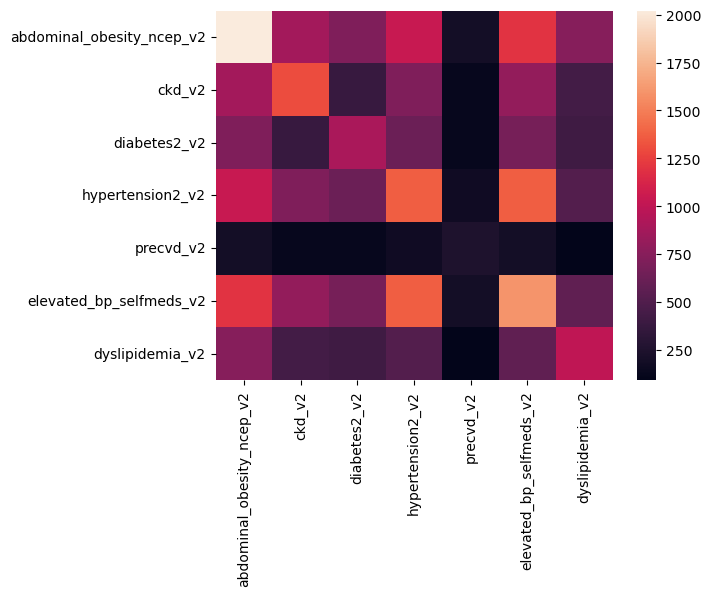

In [67]:
sns.heatmap(sub_metadata_no_nan[disease_cols].T.dot(sub_metadata_no_nan[disease_cols]))

### Num people who have multiple diseases

In [68]:
sub_metadata_no_nan['total_diseases'] = sub_metadata_no_nan[disease_cols].sum(axis=1)
sub_metadata_no_nan['total_diseases'].value_counts()

2.0    599
4.0    565
3.0    517
1.0    513
5.0    385
0.0    198
6.0    139
7.0     22
Name: total_diseases, dtype: int64

In [77]:
sub_metadata_no_nan[disease_cols].sum()

abdominal_obesity_ncep_v2    2021.0
ckd_v2                       1301.0
diabetes2_v2                  900.0
hypertension2_v2             1367.0
precvd_v2                     247.0
elevated_bp_selfmeds_v2      1597.0
dyslipidemia_v2              1002.0
dtype: float64

In [79]:
sub_metadata_no_nan['diabetes2_v2'].value_counts()

0.0    2038
1.0     900
Name: diabetes2_v2, dtype: int64

In [85]:
sub_metadata_no_nan['abdominal_obesity_ncep_v2'].corr(sub_metadata_no_nan['ckd_v2'])

-0.03243933130610738

# Model Creation

In [70]:
def binary_to_tf(val):
    if val==1.0:
        return 'T'
    elif val==0.0:
        return 'F'
    else:
        return 'missing'

In [93]:
sub_metadata_no_nan['abdominal_obesity_ncep_v2'] = sub_metadata_no_nan['abdominal_obesity_ncep_v2'].apply(lambda x: binary_to_tf(x))

In [94]:
sub_metadata_no_nan

,abdominal_obesity_ncep_v2,ckd_v2,diabetes2_v2,hypertension2_v2,precvd_v2,elevated_bp_selfmeds_v2,dyslipidemia_v2,gender_v2,agegroup_c6_v2,bmigrp_c6_v2,center,us_born_v2,income_c5_v2,total_diseases
sample_name,,,,,,,,,,,,,,
11666.G0001A,T,0.0,0.0,1.0,0.0,1.0,0.0,F,4.0,4.0,M,0.0,1.0,3.0
11666.G0001L,T,0.0,0.0,1.0,0.0,1.0,0.0,F,4.0,4.0,M,0.0,1.0,3.0
11666.G0003A,T,0.0,0.0,0.0,0.0,0.0,0.0,F,4.0,3.0,B,1.0,4.0,1.0
11666.G0003L,T,0.0,0.0,0.0,0.0,0.0,0.0,F,4.0,3.0,B,1.0,4.0,1.0
11666.G0004A,F,1.0,0.0,1.0,0.0,1.0,0.0,M,5.0,3.0,B,0.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11666.G1777A,F,1.0,0.0,1.0,0.0,1.0,1.0,M,3.0,3.0,C,1.0,4.0,4.0
11666.G1778A,T,1.0,0.0,1.0,1.0,1.0,0.0,F,6.0,3.0,S,0.0,3.0,5.0
11666.G1779A,T,0.0,1.0,1.0,0.0,1.0,0.0,F,5.0,3.0,S,0.0,2.0,4.0


In [95]:
sub_metadata_no_nan.to_csv("data/temp/updated_metadata.tsv",sep="\t")

### Qiime metadata

convert df to qiime metadata

Only need the following if using Artifact API

In [74]:
from qiime2 import Metadata

In [96]:
qiime_metadata = Metadata.load("data/temp/updated_metadata.tsv")
# qiime_metadata.save('qiime_metadata.qza')

In [117]:
qiime_metadata

Metadata
--------
2938 IDs x 14 columns
abdominal_obesity_ncep_v2: ColumnProperties(type='categorical', missing_scheme='blank')
ckd_v2:                    ColumnProperties(type='numeric', missing_scheme='blank')
diabetes2_v2:              ColumnProperties(type='numeric', missing_scheme='blank')
hypertension2_v2:          ColumnProperties(type='numeric', missing_scheme='blank')
precvd_v2:                 ColumnProperties(type='numeric', missing_scheme='blank')
elevated_bp_selfmeds_v2:   ColumnProperties(type='numeric', missing_scheme='blank')
dyslipidemia_v2:           ColumnProperties(type='numeric', missing_scheme='blank')
gender_v2:                 ColumnProperties(type='categorical', missing_scheme='blank')
agegroup_c6_v2:            ColumnProperties(type='numeric', missing_scheme='blank')
bmigrp_c6_v2:              ColumnProperties(type='numeric', missing_scheme='blank')
center:                    ColumnProperties(type='categorical', missing_scheme='blank')
us_born_v2:             

In [99]:
from qiime2.plugins.sample_classifier.pipelines import classify_samples

/Users/amando/opt/anaconda3/envs/qiime2-2022.8/lib/python3.8/site-packages/seaborn/matrix.py:1210: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


Results (name = value)
-------------------------------------------------------------------------------------------------------------
sample_estimator   = <artifact: SampleEstimator[Classifier] uuid: f718d24b-70c3-4583-a306-88020d100abf>
feature_importance = <artifact: FeatureData[Importance] uuid: b5adeaa8-7528-4243-a789-b991173c17f0>
predictions        = <artifact: SampleData[ClassifierPredictions] uuid: a790239a-5e3f-4337-94c5-d49b3b7b2387>
model_summary      = <visualization: Visualization uuid: 40a22620-e6da-43f4-8ee9-43bf68c4c957>
accuracy_results   = <visualization: Visualization uuid: a33134b4-b8f0-4b2b-8cc9-888c20f836c6>
probabilities      = <artifact: SampleData[Probabilities] uuid: e10efca0-4d0d-442d-8356-2857cd86bf3b>
heatmap            = <visualization: Visualization uuid: 16498437-6373-41dc-b61c-8dd1cc191639>
training_targets   = <artifact: SampleData[TrueTargets] uuid: bfbb9507-ee0d-4731-b5a9-1e143c64a89f>
test_targets       = <artifact: SampleData[TrueTargets] uuid: 8e53

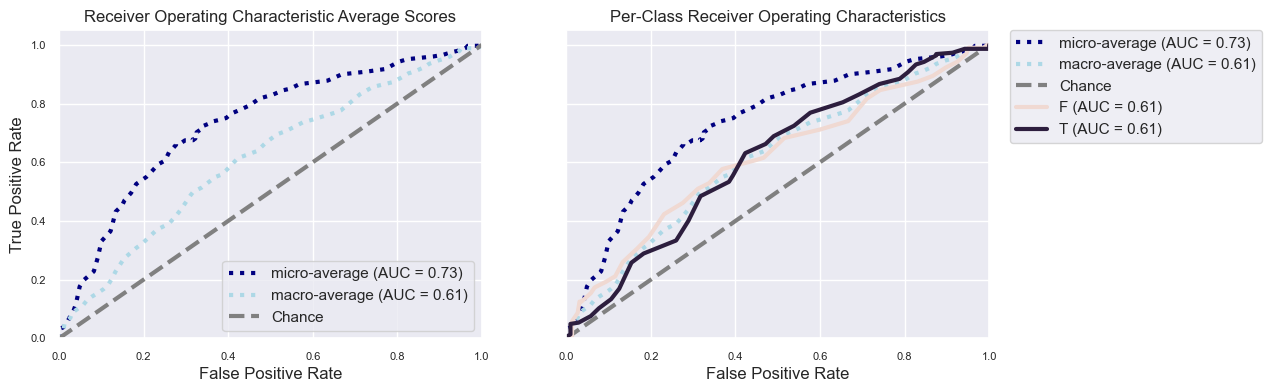

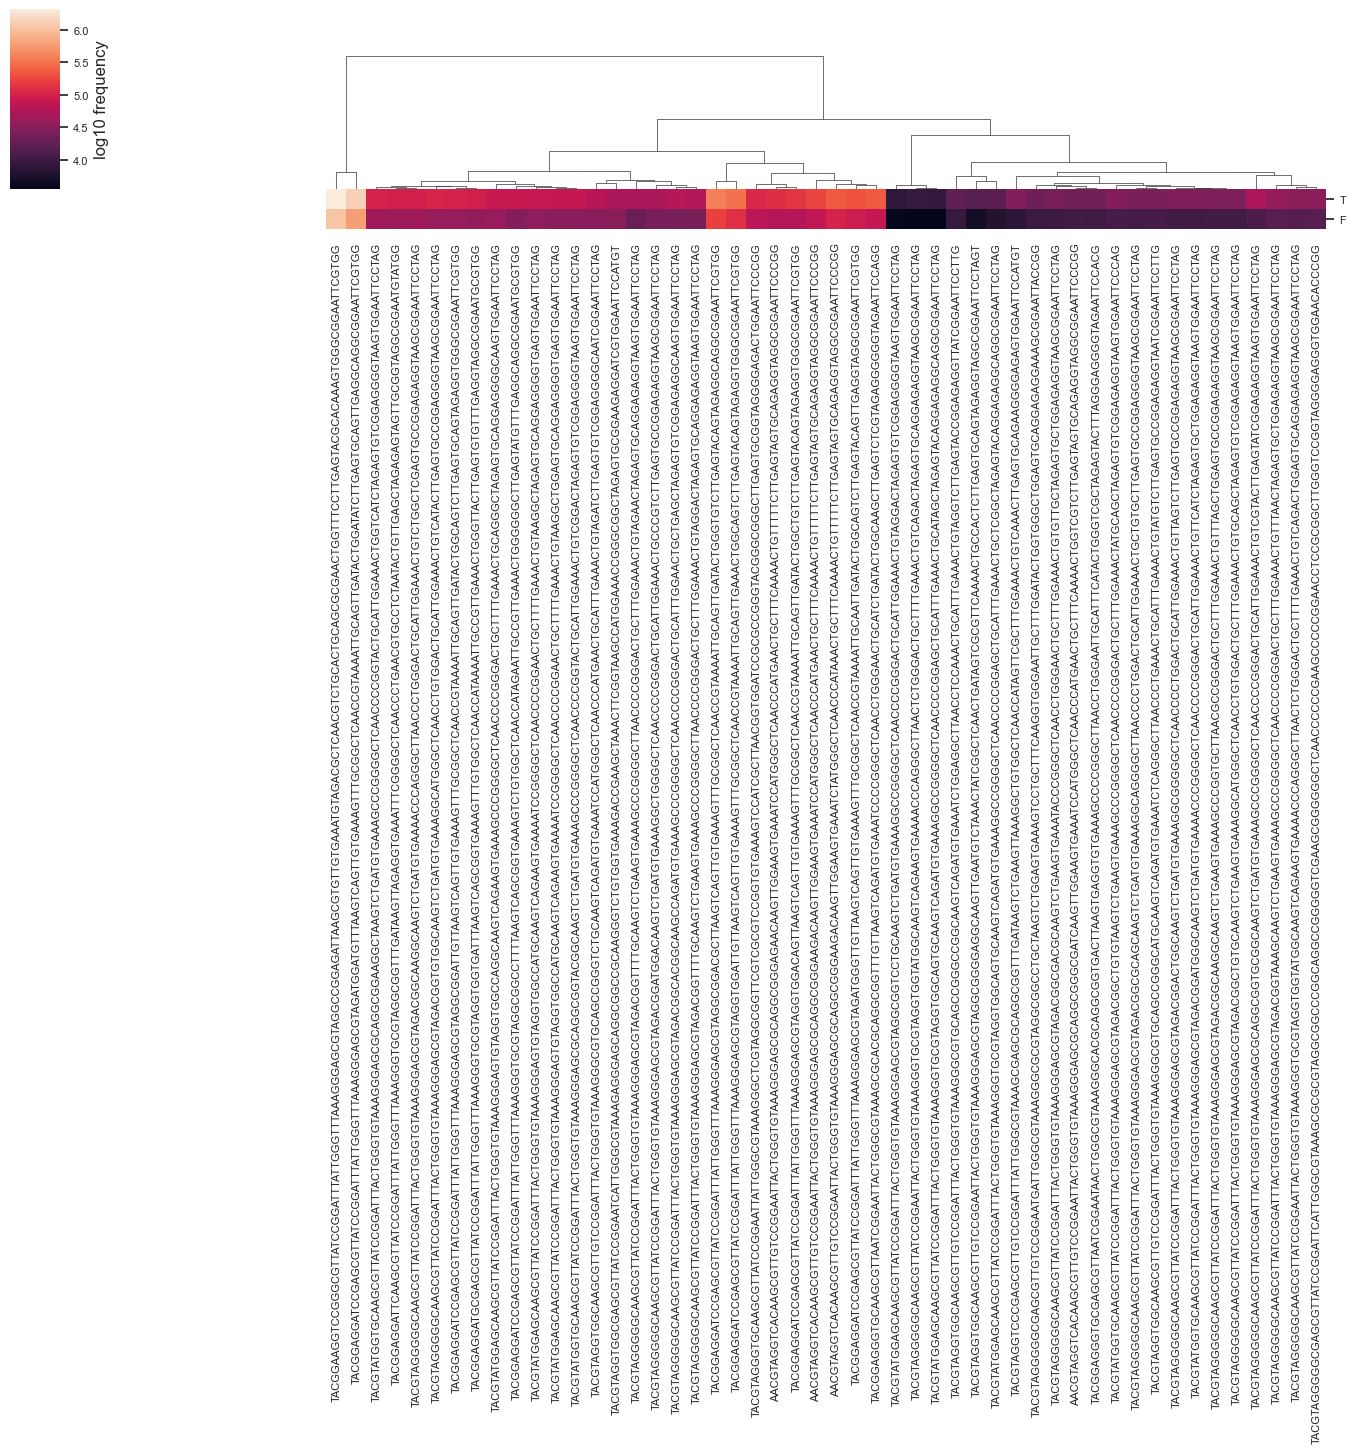

In [116]:
classify_samples(feature_table, qiime_metadata.get_column('abdominal_obesity_ncep_v2'), missing_samples='ignore')